In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score,adjusted_rand_score
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

### Guidelines for data plotting

When asked to produce a plot, you must:

1. Follow directions on whether to use a line plot or scatter plot
2. Provide descriptive labels for all axes and give units when indicated
3. Provide a descriptive title for the plot
4. Provide a descriptive legend for the plot when plotting more than one dataset
5. Use color or marker to differentiate between datasets when plotting more than one dataset

### Guidelines for report numerical and text-based answers

1. When asked to report a numerical value (e.g. a validation score), you must include a print statement that describes the value being reported either together or directly before the printing of the value itself.

2. When asked to answer a question with text, create a new text cell and answer the question in complete sentances.

#1. Predicting a Pulsar Star

### Dataset Description

HTRU2 is a data set which describes a sample of pulsar candidates collected during the High Time Resolution Universe Survey. Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter.

As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes. Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

### Attribute Information

Each candidate is described by 8 continuous variables, and a single class variable. The first four are simple statistics obtained from the integrated pulse profile (folded profile). This is an array of continuous variables that describe a longitude-resolved version of the signal that has been averaged in both time and frequency . The remaining four variables are similarly obtained from the DM-SNR curve . These are summarised below:
- Mean of the integrated profile.
- Standard deviation of the integrated profile.
- Excess kurtosis of the integrated profile.
- Skewness of the integrated profile.
- Mean of the DM-SNR curve.
- Standard deviation of the DM-SNR curve.
- Excess kurtosis of the DM-SNR curve.
- Skewness of the DM-SNR curve.


#### Step 0: Download the data

In [ ]:
!wget https://raw.githubusercontent.com/alexandrehsd/Predicting-Pulsar-Stars/master/pulsar_stars.csv

--2023-04-26 00:22:10--  https://raw.githubusercontent.com/alexandrehsd/Predicting-Pulsar-Stars/master/pulsar_stars.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1748317 (1.7M) [text/plain]
Saving to: ‘pulsar_stars.csv’

pulsar_stars.csv    100%[===================>]   1.67M  --.-KB/s    in 0.02s   

2023-04-26 00:22:10 (95.3 MB/s) - ‘pulsar_stars.csv’ saved [1748317/1748317]



### Step 1: Prepare the data for modeling

1. **Load the dataset as a dataframe**.
2. **Prepare the feature data `X` by extracting the data in the columns described in the problem statement.**
3. **Prepare the target data `y` by extracting the data in the `target_class` column.**
3. **Split the dataset into training and testing sets.**

In [ ]:
df = pd.read_csv('pulsar_stars.csv')
x = df.drop(['target_class'],axis = 1).values
y = df['target_class'].values
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=1234)

#### Step 3: Hyperparameter optimization for pulsar detection with linear SVM

1. **Construct a modeling `sklearn.pipeline.Pipeline` for fitting the data.** The pipeline should include:
  - `sklearn.preprocessing.StandardScaler` standardization transformation.
  - `sklearn.svm.SVC` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) support vector classification model.
2. **Perform a grid search `GridSearchCV`** over
  - `C`: the regularization penalty strength parameter
3. **Print out the best cross-validation score and corresponding parameters.**
4. Retrain the `SVC` model with the best hyperparameters using the entire training set. **Calculate the precision and recall of both the positive class and negative class on the test set.** Write a comment interpreting the results of these metric calculations.

You may select the range of possible hyperparameter values, but you must compare at least 50 total models. Be sure to use the linear `SVC(kernel='linear')` support vector classifier in this step.

In [ ]:
model = Pipeline([('scaler', StandardScaler()),('svm', SVC(kernel='linear'))])

params = {'svm__C': np.logspace(-1,1,50)}

regr = GridSearchCV(model,params,cv=5)
regr.fit(x_train,y_train)

print(f'Best score: {regr.best_score_:.3f}')
print(f'Best parameters: {regr.best_params_}')

best_param = regr.best_estimator_
best_param.fit(x_train, y_train)


y_pred = best_param.predict(x_test)
precisionPositive = precision_score(y_test, y_pred,pos_label=1)
precisionNegative = precision_score(y_test, y_pred,pos_label=0)
recallPositive = recall_score(y_test, y_pred,pos_label=1)
recallNegative = recall_score(y_test, y_pred,pos_label=0)
print(f"Positive Precision: {precisionPositive}")
print(f"Negative Precision: {precisionNegative}")
print(f"Positive Recall: {recallPositive}")
print(f"Negative Recall: {recallNegative}")

Best score: 0.979
Best parameters: {'svm__C': 0.7196856730011519}
Positive Precision: 0.9351351351351351
Negative Precision: 0.9817295980511571
Positive Recall: 0.8218527315914489
Negative Recall: 0.9940799210656142


From these results, all of the scores are extremely high. The lowest score was .82 for the positive recall. This means this model is extrmely accurate at predictions.

#### Step 4: Class-Balancing

Repeat the analysis in Step 3, but use the class-balancing option `SVC(kernel='linear', class_weight='balanced')` for all models. Write a comment comparing the precision and recall scores of the best class-balanced model with the original analysis in Step 3.

In [ ]:
model = Pipeline([('scaler', StandardScaler()),('svm', SVC(kernel='linear', class_weight = 'balanced'))])

params = {'svm__C': np.logspace(-1,1,50)}

regr = GridSearchCV(model,params,cv=5)
regr.fit(x_train,y_train)

print(f'Best score: {regr.best_score_:.3f}')
print(f'Best parameters: {regr.best_params_}')

best_param = regr.best_estimator_
best_param.fit(x_train, y_train)


y_pred = best_param.predict(x_test)
precisionPositive = precision_score(y_test, y_pred,pos_label=1)
precisionNegative = precision_score(y_test, y_pred,pos_label=0)
recallPositive = recall_score(y_test, y_pred,pos_label=1)
recallNegative = recall_score(y_test, y_pred,pos_label=0)
print(f"Positive Precision: {precisionPositive}")
print(f"Negative Precision: {precisionNegative}")
print(f"Positive Recall: {recallPositive}")
print(f"Negative Recall: {recallNegative}")

Best score: 0.975
Best parameters: {'svm__C': 0.1}
Positive Precision: 0.8272138228941684
Negative Precision: 0.9905284147557328
Positive Recall: 0.9097387173396675
Negative Recall: 0.9802664035520473


The positive recall score is much metter using balanced, but the positive precision is much worse. The negative precision is marginaly better and the negative recall is marginaly worse. With all categories combined its about equal to step 3

#### Step 5: Hyperparameter optimization for pulsar detection with kernel SVM

1. **Construct a modeling `sklearn.pipeline.Pipeline` for fitting the data.** The pipeline should include:
  - `sklearn.preprocessing.StandardScaler` standardization transformation.
  - `sklearn.svm.SVC` support vector classification model.
2. **Perform a grid search `RandomizedSearchCV`** over
  - `C`: the regularization penalty strength parameter
  - `class_weight`: consider `class_weight=None` or `class_weight='balanced'`
  - `kernel`: consider the radial basis function kernel `kernel='rbf'`, the polynomial features kernel `kernel='poly'`, and the sigmoid kernel `kernel='sigmoid'`.
  - `gamma`: a scaling parameter in the `rbf`, `poly`, and `sigmoid` kernels. Consider `gamma='scale'` or `gamma='auto'`.
3. **Print out the best cross-validation score and corresponding parameters.**
4. Retrain the `SVC` model with the best hyperparameters using the entire training set. **Calculate the precision and recall of both the positive class and negative class on the test set.** Write a comment interpreting the results of these metric calculations.

You may select the range of possible hyperparameter values, but you must compare at least 50 total models. In this case, you should use a dense ~50 length array of choices for `C`. This, together with the other considerations described in the problem statement, will produce ~1200 hyperparameter combinations. The `RandomizedSearchCV` will randomly select a subset of these to actually test and report. Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) to learn how to control the number of hyperparameter sets selected for testing.

In [ ]:
model = Pipeline([('scaler', StandardScaler()),('svm', SVC())])

params = {
    'svm__C': np.logspace(-3,3,50),
    'svm__class_weight' : [None,'balanced'],
    'svm__kernel' : ['rbf','poly','sigmoid'],
    'svm__gamma' : ['scale']
    }
search = RandomizedSearchCV(model,params)
search.fit(x_train,y_train)
print(f'Best score: {search.best_score_:.3f}')
print(f'Best parameters: {search.best_params_}')
best_model = search.best_estimator_
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
precisionPositive = precision_score(y_test, y_pred,pos_label=1)
precisionNegative = precision_score(y_test, y_pred,pos_label=0)
recallPositive = recall_score(y_test, y_pred,pos_label=1)
recallNegative = recall_score(y_test, y_pred,pos_label=0)
print(f"Positive Precision: {precisionPositive}")
print(f"Negative Precision: {precisionNegative}")
print(f"Positive Recall: {recallPositive}")
print(f"Negative Recall: {recallNegative}")

Best score: 0.979
Best parameters: {'svm__kernel': 'rbf', 'svm__gamma': 'scale', 'svm__class_weight': None, 'svm__C': 2.023589647725158}
Positive Precision: 0.9276139410187667
Negative Precision: 0.9817162359824476
Positive Recall: 0.8218527315914489
Negative Recall: 0.993339911198816


The scores on the are extremely good, and extremely similar to step 3. The results are every so slightly worse than step 3, but it is extremely close.

#### Step 6. Selecting a an appropriate metric

Suppose you would like to select a model that balances maximizing the identification of positive examples within a given test set and minimizing the false positive rate. **What metric would you use? Explain your reasoning. Use this metric to perform hyperparameter optimization cross-validation model selection and repeat the analysis in Step 5. Do the number of positive examples identified in the test set improve over the default (Accuracy) selection metric?**

# 2. Gene Expression Clustering

This gene expression dataset consists of 40 tissue samples with measurements on 1000 genes. The first 20 samples are from healthy patients, while the second 20 samples are from a diseased group.

In [ ]:
!wget https://www.statlearning.com/s/Ch10Ex11.csv

--2023-04-26 00:46:55--  https://www.statlearning.com/s/Ch10Ex11.csv
Resolving www.statlearning.com (www.statlearning.com)... 198.185.159.144, 198.49.23.145, 198.185.159.145, ...
Connecting to www.statlearning.com (www.statlearning.com)|198.185.159.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe072c4c46034a4567141/1610604659250/Ch10Ex11.csv [following]
--2023-04-26 00:46:55--  https://static1.squarespace.com/static/5ff2adbe3fe4fe33db902812/t/5fffe072c4c46034a4567141/1610604659250/Ch10Ex11.csv
Resolving static1.squarespace.com (static1.squarespace.com)... 151.101.0.238, 151.101.64.238, 151.101.128.238, ...
Connecting to static1.squarespace.com (static1.squarespace.com)|151.101.0.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 403088 (394K) [text/csv]
Saving to: ‘Ch10Ex11.csv’

Ch10Ex11.csv        100%[===================>] 393.64K  --.-KB/s    in 0.006

### Step 1. Load the dataset

Read the data to a dataframe and construct an array `X` containing the gene expression measurements of each tissue sample. Construct an array of labels `y` that contains the sample class (healthy `0` or diseased `1`) based on the information given in the problem statement.

In [ ]:
df = pd.read_csv('Ch10Ex11.csv').T
x = df.iloc[:,1:].values.astype(float)
y = df.iloc[:,0].values.astype(float)

### Step 2. Hierarchical clustering

Apply hierarchical clustering with `sklearn.cluster.AgglomerativeClustering` to the samples using the `metric='cosine'` keyword argument (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)). Plot the dendrogram. Do the genes separate the samples into the two groups? Next, change the keyword argument `linkage` to some acceptable value other than `ward` (the default). Do the results depend on the type of linkage method used?

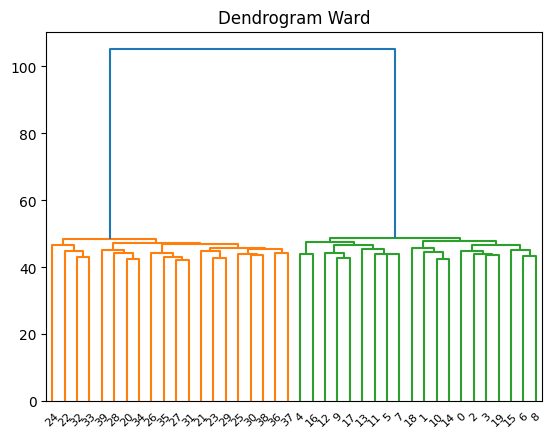

In [ ]:
cluster = AgglomerativeClustering(n_clusters=None, metric=None, linkage='ward', distance_threshold=0)
cluster = cluster.fit(x)
plt.title("Dendrogram Ward")
dend = shc.dendrogram(shc.linkage(x, method='ward'))
plt.show()


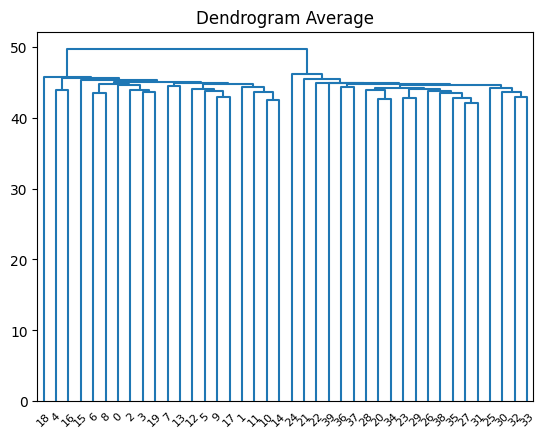

In [ ]:
cluster = AgglomerativeClustering(n_clusters=None, metric='cosine', linkage='average', distance_threshold=0)
cluster = cluster.fit(x)
plt.title("Dendrogram Average")
dend = shc.dendrogram(shc.linkage(x, method='average'))
plt.show()

The results relatively similar, with the main difference being the inital height of the first split. It is hard to say if the linkage is the sole dependant method. The main reason for this is that when the linkage is set to ward, and the metric is set to cosine it produces the eroor " cosine was provided as metric. Ward can only work with euclidean distances" This error is only fixed by setting metric to none. Becuase of this It is hard to tell if the results do depend on the linkage, but I do believe they do.

### Step 3. Determine important gene variations

Your collaborator wants to know which genes differ the most across the two groups. Suggest a way to answer this question, and apply it here.

#3. Clustering Synthetic Data

### Step 1. Generate synthetic dataset

Generate a synthetic dataset with 20 observations in each of three classes (i.e. 60 observations total) and 50 variables. HINT: You can use the `sklearn.datasets.make_classification` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification/)) function to generate data.

In [ ]:
x,y = make_classification(n_samples=60,n_features=50,n_classes=3, n_clusters_per_class=1)

### Step 2. Perform PCA

Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to Step 3. If not, then return to Step 1 and modify the data generation so that there is greater separation between the three classes.

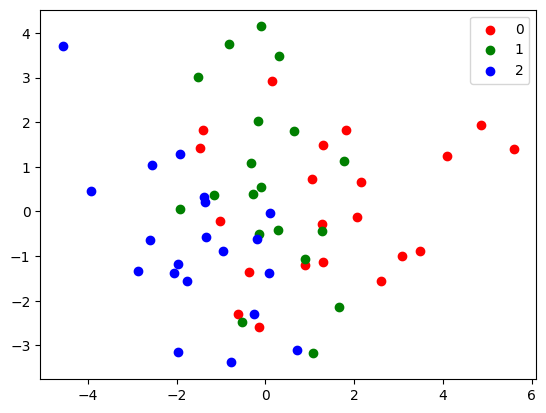

In [ ]:
pca = PCA(n_components =2)
x_pca = pca.fit_transform(x)

colors = ['r','g','b']
for class_label, color in zip(set(y),colors):
  plt.scatter(x_pca[y==class_label,0], x_pca[y==class_label,1],color=color,label=class_label)
plt.legend()
plt.show()

### Step 3. K-means Clustering

Perform K-means clustering of the observations with $K=2$, $K=3$, and $K=4$. Describe your results. How well do the clusters that you obtained in K-means clustering compare to the true class labels?

In [ ]:
true_labels = y
for n_clusters in range(2,5):
  kmeans = KMeans(n_clusters=n_clusters)
  pred = kmeans.fit_predict(x)
  print("True Labels")
  print(true_labels)
  print("prediction")
  print(pred)


True Labels
[0 2 2 0 1 1 0 0 0 2 2 1 2 0 2 0 0 0 2 1 1 1 0 1 1 2 1 0 1 0 2 0 2 1 0 0 2
 1 2 2 1 0 2 1 1 0 1 2 0 1 2 2 1 2 0 2 0 2 1 0]
prediction
[1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0]
True Labels
[0 2 2 0 1 1 0 0 0 2 2 1 2 0 2 0 0 0 2 1 1 1 0 1 1 2 1 0 1 0 2 0 2 1 0 0 2
 1 2 2 1 0 2 1 1 0 1 2 0 1 2 2 1 2 0 2 0 2 1 0]
prediction
[1 1 1 0 2 0 1 1 2 1 1 0 1 2 1 0 1 1 1 1 0 2 1 2 1 1 1 2 0 1 1 0 1 2 0 0 1
 1 1 1 0 2 1 2 2 0 1 1 0 2 0 1 0 1 2 1 1 1 1 2]
True Labels
[0 2 2 0 1 1 0 0 0 2 2 1 2 0 2 0 0 0 2 1 1 1 0 1 1 2 1 0 1 0 2 0 2 1 0 0 2
 1 2 2 1 0 2 1 1 0 1 2 0 1 2 2 1 2 0 2 0 2 1 0]
prediction
[1 0 1 1 1 3 1 2 1 0 2 1 3 1 1 1 0 1 2 2 2 2 0 1 2 0 2 1 1 2 2 1 1 1 1 1 0
 2 2 1 3 1 2 2 2 1 0 0 1 2 3 3 1 1 1 0 1 1 2 1]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The results show that K = 3 has the closest predictions to the true class labels, but overall each have poor values which means k-means clustering is not a good match for the class labels.

### Step 4. PCA + K-means

Perform K-means clustering with $K=3$ on the first two principal component score vectors, rather than on the raw data. That is, perform K-means clustering on the [60, 2] array of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results.

In [ ]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca = kmeans_pca.fit(x_pca[:,:2])
print("PCA")
print(kmeans_pca.labels_)
print("True labels")
print(true_labels)

PCA
[0 0 0 1 1 1 2 0 2 0 1 1 1 0 0 2 1 2 0 1 0 2 2 2 1 0 0 2 1 0 0 2 0 1 2 0 0
 0 0 0 1 2 0 1 0 1 1 0 2 0 1 1 1 1 2 1 0 0 0 2]
True labels
[0 2 2 0 1 1 0 0 0 2 2 1 2 0 2 0 0 0 2 1 1 1 0 1 1 2 1 0 1 0 2 0 2 1 0 0 2
 1 2 2 1 0 2 1 1 0 1 2 0 1 2 2 1 2 0 2 0 2 1 0]


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Overall the results from the principal components are much better

### Step 5. Scaling + K-means

Using the `sklearn.preprocessing.StandardScaler()` class or similar, perform K-means clustering with $K=3$ on the data after scaling each variable to have standard deviation one. How do these results compare to the results from Step 3?

In [ ]:
data = StandardScaler().fit_transform(x)
kmeans_scaler = KMeans(n_clusters=3)
kmeans_scaler = kmeans_scaler.fit(data)
print("Scaled Data")
print(kmeans_scaler.labels_)
print("True Lables")
print(true_labels)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Scaled Data
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 1 1 1 2 2 2 2 1 1 2 1 1 2 2 1
 2 2 2]
True Lables
[0 2 2 0 1 1 0 0 0 2 2 1 2 0 2 0 0 0 2 1 1 1 0 1 1 2 1 0 1 0 2 0 2 1 0 0 2
 1 2 2 1 0 2 1 1 0 1 2 0 1 2 2 1 2 0 2 0 2 1 0]


The results from scaling the data is signifcantly worse than step 3